In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.cm as cm

In [ ]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

# using 3000 data for test
train_x=train_x[:3000]
train_y=train_y[:3000]

# using 1000 data for test
test_x=test_x[:1000]
test_y=test_y[:1000]

train_x, test_x = train_x/255.0, test_x/255.0

train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

n_train = train_x.shape[0]
n_test = test_x.shape[0]

print ("The number of training images : {}, shape : {}".format(n_train, train_x.shape))
print ("The number of testing images : {}, shape : {}".format(n_test, test_x.shape))

11501568/11490434 [==============================] - 0s 0us/step
The number of training images : 3000, shape : (3000, 28, 28, 1)
The number of testing images : 1000, shape : (1000, 28, 28, 1)


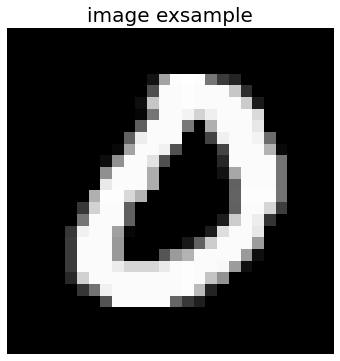

In [ ]:
idx = np.random.randint(n_train)
plt.figure(figsize = (8,6))
plt.imshow(train_x[idx][:,:,0], 'gray')
plt.title('image exsample', fontsize = 20)
plt.axis('off')
plt.show()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32,
                          kernel_size = (3, 3),
                          activation = 'relu',
                          padding = 'SAME',
                          input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters = 64,
                          kernel_size = (3, 3),
                          activation = 'relu',
                          padding = 'SAME',
                          input_shape = (14, 14, 32)),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 32, activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
])

In [ ]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = 'accuracy')

In [ ]:
history=model.fit(train_x, train_y, epochs = 10, batch_size = 64)

Epoch 1/10
47/47 [==============================] - 14s 6ms/step - loss: 1.2061 - accuracy: 0.6240
Epoch 2/10
47/47 [==============================] - 0s 4ms/step - loss: 0.3635 - accuracy: 0.8857
Epoch 3/10
47/47 [==============================] - 0s 4ms/step - loss: 0.2361 - accuracy: 0.9320
Epoch 4/10
47/47 [==============================] - 0s 4ms/step - loss: 0.1652 - accuracy: 0.9547
Epoch 5/10
47/47 [==============================] - 0s 4ms/step - loss: 0.1364 - accuracy: 0.9623
Epoch 6/10
47/47 [==============================] - 0s 4ms/step - loss: 0.1154 - accuracy: 0.9667
Epoch 7/10
47/47 [==============================] - 0s 7ms/step - loss: 0.0876 - accuracy: 0.9750
Epoch 8/10
47/47 [==============================] - 0s 7ms/step - loss: 0.0767 - accuracy: 0.9787
Epoch 9/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0572 - accuracy: 0.9840
Epoch 10/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0473 - accuracy: 0.9870


In [ ]:
model.evaluate(test_x, test_y)

32/32 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 0.9610


[0.12477478384971619, 0.9610000252723694]

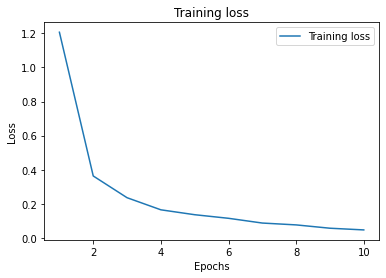

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["loss"]

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="Training loss")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

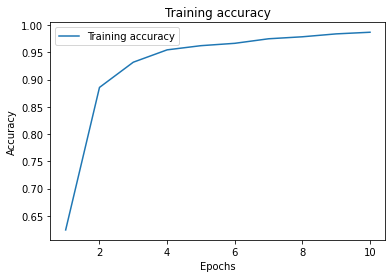

In [ ]:
plt.clf()
acc = history.history["accuracy"]

plt.plot(epochs, acc, label="Training accuracy")

plt.title("Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


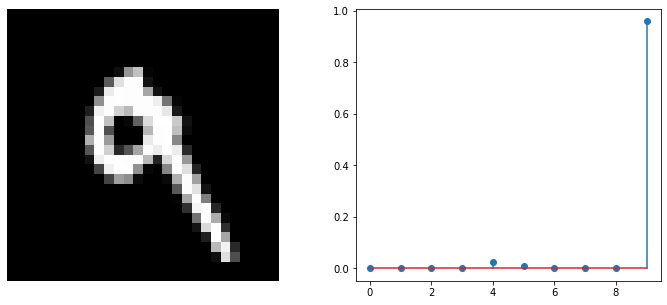

Prediction : 9


In [ ]:
test_idx = [7]
test_img = test_x[test_idx]

predict = model.predict(test_img)
mypred = np.argmax(predict, axis = 1)

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_img.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.stem(predict[0])
plt.show()

print('Prediction : {}'.format(mypred[0]))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 32)                1

In [ ]:
def make_gradcam_heatmap(img_array, model, conv_layer_name, pred_index=None):
    # 입력에 따른 피처 맵 모델 생성
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(conv_layer_name).output, model.output]
    )
    #출력에 따른 Gradient 계산 함수
    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 예측된 값에 대한 Gradient 호출
    grads = tape.gradient(class_channel, conv_layer_output)

    # 각 피쳐 맵에 대한 가중치 산출
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 계산된 가중치와 해당 레이어를 곱하여 얼마나 중요도를 가지는지 히트맵 계산
    conv_layer_output = conv_layer_output[0]
    heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 시각화를 위해 0-1 범위로 정규화 및 ReLU 수행
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

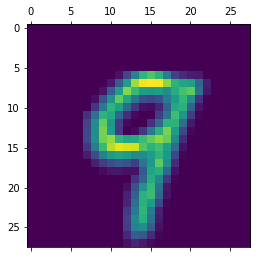

In [ ]:
test_img = test_x[[123]]
layer_name = 'conv2d'
heatmap = make_gradcam_heatmap(test_x[[12]], model, layer_name)
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_input, heatmap, cam_path = "cam.jpg",  alpha=0.01):
    # Load the original image
    img =img_input.reshape(28,28)
    img = keras.preprocessing.image.img_to_array(img)

    # 정규화된 Heatmap 이미지를 0-255 범위로 변환
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")

    # 계산된 값을 RGB 값으로 변경 및 이미지 변환
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # 계산한 Heatmap과 입력 이미지 결합
    # alpha 값을 통해 입력 이미지의 투명도 계산
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # 생성된 이미지 저장
    superimposed_img.save(cam_path)

    # 가시화
    plt.imshow(superimposed_img)

In [ ]:
layer_name = 'conv2d'
layer_output = model.get_layer(layer_name).output
experiment = test_x[[1]]

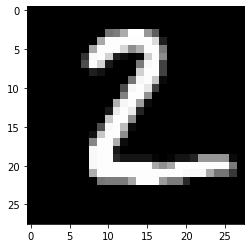

In [ ]:
plt.imshow(experiment.reshape(28,28),'gray')
plt.show()

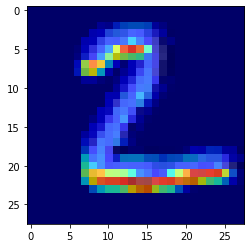

In [ ]:
make_heatmap = make_gradcam_heatmap(experiment, model, layer_name)
save_and_display_gradcam(experiment, make_heatmap)

In [ ]:
## 1, 7, 9를 비교하여 Grad CAM이 어느 부분을 통해 판별하는지 점검 수행

list_1 = []
list_7 = []
list_9 = []

for i in range(1000):
    if test_y[i] == 1:
        list_1.append(i)
    if test_y[i] == 7:
        list_7.append(i)
    if test_y[i] == 9:
        list_9.append(i)

In [ ]:
test_idx_1 = [list_1[np.random.randint(0, 90)]]
test_image_1 = test_x[test_idx_1]

test_idx_2 = [list_7[np.random.randint(0, 90)]]
test_image_2 = test_x[test_idx_2]

test_idx_3 = [list_9[np.random.randint(0, 90)]]
test_image_3 = test_x[test_idx_3]

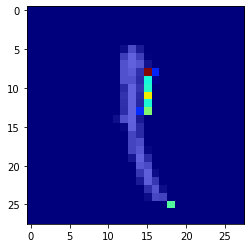

In [ ]:
make_heatmap = make_gradcam_heatmap(test_image_1, model, layer_name)
save_and_display_gradcam(test_image_1, make_heatmap)


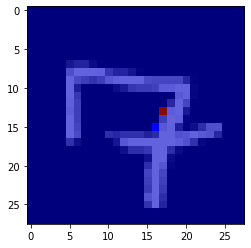

In [ ]:
make_heatmap = make_gradcam_heatmap(test_image_2, model, layer_name)
save_and_display_gradcam(test_image_2, make_heatmap)

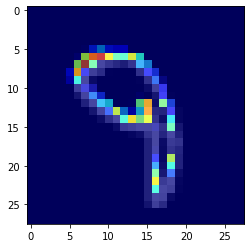

In [ ]:
make_heatmap = make_gradcam_heatmap(test_image_3, model, layer_name)
save_and_display_gradcam(test_image_3, make_heatmap)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image    import img_to_array, load_img
from tensorflow.keras.applications.vgg16     import (preprocess_input, decode_predictions)

In [ ]:
!wget https://url.kr/argi5c -O 'images.zip'
!unzip images.zip -d './images'

--2022-09-06 09:37:03--  https://url.kr/argi5c
Resolving url.kr (url.kr)... 183.111.169.122
Connecting to url.kr (url.kr)|183.111.169.122|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://url.kr/include/url_spam_filtering_system.php?short=argi5c [following]
--2022-09-06 09:37:04--  https://url.kr/include/url_spam_filtering_system.php?short=argi5c
Reusing existing connection to url.kr:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/MinseokOff/KSME_advanced/raw/main/LRP/images.zip [following]
--2022-09-06 09:37:05--  https://github.com/MinseokOff/KSME_advanced/raw/main/LRP/images.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MinseokOff/KSME_advanced/main/LRP/images.zip [following]
--2022-09-06 09:37:05--  https://raw.githubusercontent.com/MinseokO

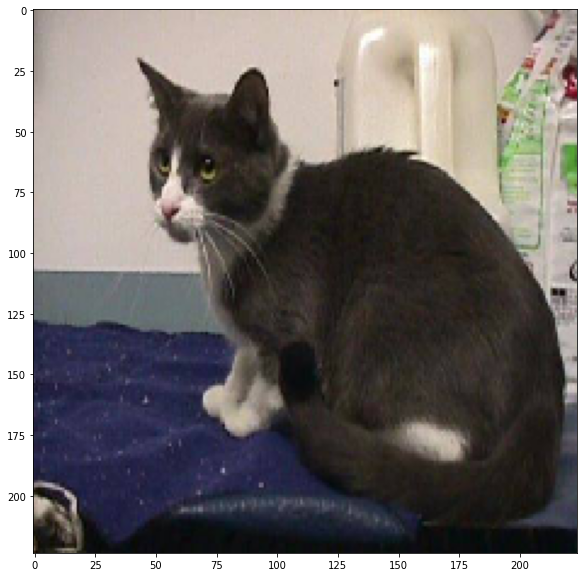

In [ ]:
model_builder = tf.keras.applications.vgg16.VGG16

preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

# 이미지 경로
# image_ = load_img('data/cat.1.jpg', target_size=(224, 224))
image_= load_img('./images/cat.1.jpg', target_size=(224, 224))
plt.figure(figsize=(10,10))
plt.imshow(image_)

In [ ]:
model = model_builder(weights="imagenet")
model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02123045', 'tabby', 0.09234088)]


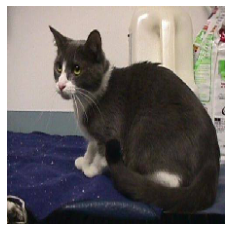

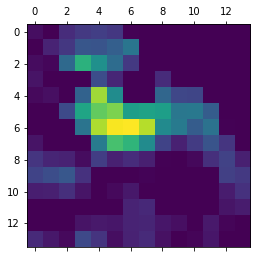

In [ ]:
last_conv_layer_name = "block5_conv3"


processed_images = []

image_= load_img('./images/cat.1.jpg', target_size=(224, 224))
plt.imshow(image_)
plt.axis('off')

# 학습에 사용할 이미지를 3차원 배열로 변환 및 전처리하는 코드
# processed_images에는 학습에 사용할 이미지가 들어가게 된다.

image = img_to_array(image_)
image = preprocess_input(image)
processed_images.append(image)
processed_images = np.array(processed_images)


# 모델의 예측 결과 표현
preds = model.predict(processed_images)
print("Predicted:", decode_predictions(preds, top=1)[0])

# 히트맵 생성
heatmap = make_gradcam_heatmap(processed_images, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_, heatmap, cam_path="cam.jpg", alpha=0.4):
   
    img = keras.preprocessing.image.img_to_array(img_)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

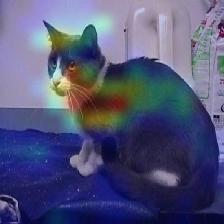

In [ ]:
save_and_display_gradcam(image_, heatmap)